In [1]:
from importlib import reload
from load_cluster_data import load_cluster_data
import gc

import numpy as np
import torch
import pandas as pd 
import seaborn as sns
import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 10

import plotnine as p9
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import splicing_PCA_utils
from nuclear_norm_PCA import sparse_sum

from pca_kmeans_init import pca_kmeans_init
from betabinomo_LDA_singlecells_kinit import *
import betabinomo_LDA_singlecells_kinit
reload(betabinomo_LDA_singlecells_kinit)


cpu


/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


<module 'betabinomo_LDA_singlecells_kinit' from '/gpfs/commons/home/kisaev/leafcutter-sc/src/beta-binomial-lda/betabinomo_LDA_singlecells_kinit.py'>

### Load data

In [2]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'

In [3]:
summarized_data = pd.read_hdf(input_file, 'df')
summarized_data.head()

,cell_id,Cluster,Cluster_Counts,junction_id,gene_name,junc_count,score,junc_ratio,cell_id_index,junction_id_index,cell_type
0,B_10_10_3,371,1,1_29039426_29053106,EPB41,1,150,1.0,0,18002,B
1,B_10_10_3,509,1,1_43422225_43422479,SZT2,1,82,1.0,0,18599,B
2,B_10_10_3,576,2,1_1709133_1709517,CDK11A,1,206,0.5,0,17445,B
3,B_10_10_3,576,2,1_1709640_1712263,CDK11A,1,1245,0.5,0,17446,B
4,B_10_10_3,763,1,1_19124690_19126445,UBR4,1,270,1.0,0,17503,B


In [4]:
print(len(summarized_data.cell_id.unique())) # num cells 
print(len(summarized_data.junction_id.unique())) # num junctions
print(len(summarized_data.Cluster.unique())) # num Cluster

65457
38802
11585


In [5]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])

# still do preprocessing in scipy
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

['B' 'CD14Mono' 'CD8T' 'DC' 'FCGR3A' 'IGHA' 'MemoryCD4T' 'NK' 'NaiveCD4T'
 'ZNF385D']


also printing original indices of junctions we are keeping


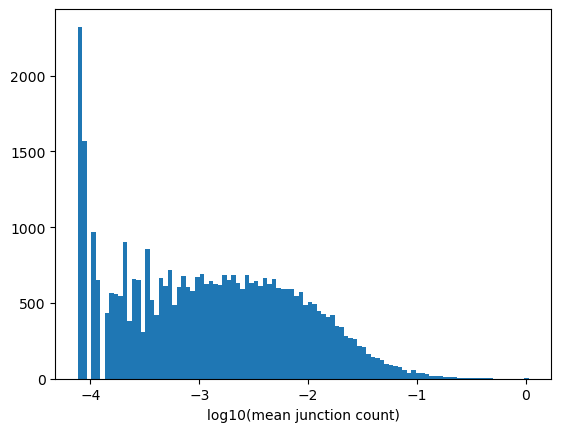

In [6]:
junc_counts_sub, cluster_counts_sub, to_keep = splicing_PCA_utils.filter_junctions(
    junc_counts, cluster_counts, plot = True)

junc_ind_keep = junction_ids_conversion["junction_id_index"][to_keep]
final_data = final_data[final_data.junction_id_index.isin(junc_ind_keep)]

In [7]:
junction_ids_conversion=junction_ids_conversion[to_keep]
junction_ids_conversion["new_junction_id_index"] = np.arange(junction_ids_conversion.shape[0])

In [8]:
# re-order the remaining junctions 
final_data = final_data.merge(junction_ids_conversion, on = "junction_id_index")
final_data

,cell_id_index,junction_id_index,junc_count,cluster_count,clustminjunc,juncratio,cell_id,cell_type,junction_id,Cluster,new_junction_id_index
0,0,2527,1.0,1,0.0,1.0,B_10_10_3,B,11_60466157_60466958,6402,720
1,3,2527,3.0,5,2.0,0.6,B_10_10_66,B,11_60466157_60466958,6402,720
2,12,2527,3.0,5,2.0,0.6,B_10_13_51,B,11_60466157_60466958,6402,720
3,20,2527,1.0,1,0.0,1.0,B_10_14_90,B,11_60466157_60466958,6402,720
4,21,2527,3.0,3,0.0,1.0,B_10_15_42,B,11_60466157_60466958,6402,720
...,...,...,...,...,...,...,...,...,...,...,...
22020670,65310,36552,2.0,2,0.0,1.0,NaiveCD4T_9_62_78,NaiveCD4T,9_33443458_33443765,5720,9483
22020671,65358,36552,1.0,1,0.0,1.0,NaiveCD4T_9_81_94,NaiveCD4T,9_33443458_33443765,5720,9483
22020672,30803,36552,0.0,2,2.0,0.0,MemoryCD4T_13_12_1,MemoryCD4T,9_33443458_33443765,5720,9483
22020673,38644,36552,0.0,1,1.0,0.0,MemoryCD4T_43_59_10,MemoryCD4T,9_33443458_33443765,5720,9483


In [9]:
print(junc_counts_sub.toarray()[3, 720]) # should be 3 sanity check of data 
print(cluster_counts_sub.toarray()[3, 720]) # should be 5 sanity check of data 

3.0
5


### Simulate Data

In [10]:
sim_junc_counts = splicing_PCA_utils.simulate_junc_counts(
    cluster_counts_sub,
    cell_ids_conversion.cell_type.astype('category')
)

In [11]:
# make dataframe using the following columsn 
sim_junc_counts_flat = pd.DataFrame({"cell_id_index": sim_junc_counts.row, "new_junction_id_index": sim_junc_counts.col, "new_junc_count": sim_junc_counts.data})

# update junction counts in final_data object to be the simulated counts 
final_data = final_data.merge(sim_junc_counts_flat, on = ["cell_id_index", "new_junction_id_index"])

### Prep simulated data as input into LDA 

In [12]:
sim_data = final_data.copy() # make a copy of the data
sim_data.drop(columns = ["junc_count", "junction_id_index"], inplace = True) # drop the old junction counts and junction id index
# rename columns new_junction_id_index and new_junc_count to junction_id_index and junc_count
sim_data.rename(columns = {"new_junction_id_index": "junction_id_index", "new_junc_count": "junc_count"}, inplace = True)

In [13]:
my_data = make_torch_data(sim_data, **float_type)

/gpfs/commons/home/kisaev/leafcutter-sc/src/beta-binomial-lda/betabinomo_LDA_singlecells_kinit.py:309: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


In [14]:
my_data

IndexCountTensor(junc_index=tensor([ 720,  720,  720,  ..., 9483, 9483, 9483]), cell_index=tensor([    0,     3,    12,  ..., 30803, 38644, 38694]), y_count=tensor([0., 2., 3.,  ..., 0., 0., 0.]), t_count=tensor([0., 2., 2.,  ..., 2., 1., 1.]), cells_lookup=tensor(crow_indices=tensor([       0,      247,      476,  ..., 22019932,
                            22020201, 22020675]),
       col_indices=tensor([       0,     5682,    12502,  ..., 21622479,
                           21690254, 21862481]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]), size=(65457, 22020675),
       nnz=22020675, layout=torch.sparse_csr), ycount_lookup=tensor(crow_indices=tensor([       0,      732,     1464,  ..., 22019027,
                            22019851, 22020675]),
       col_indices=tensor([12135022, 12135023, 12135024,  ..., 13947072,
                           13947073, 13947074]),
       values=tensor([1., 0., 0.,  ..., 0., 0., 0.]), size=(10060, 22020675),
       nnz=22020675, layout=torch

### Run LDA

In [ ]:
num_trials = 1 # can't currently run more than 1 or overflow GPU memory :( 
num_iters = 300 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
for t in range(num_trials):

    # run coordinate ascent VI
    print(K)

    ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(K, my_data, float_type, hypers = hypers, num_iterations = num_iters)
    elbos_all = np.array(elbos_all)
    juncs_probs = ALPHA_f / (ALPHA_f+PI_f)
    
    theta_f = GAMMA_f / GAMMA_f.sum(1,keepdim=True)
    theta_f_plot = pd.DataFrame(theta_f.cpu())
    theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
    theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
    print(theta_f_plot_summ)
    
    # plot ELBO
    plt.plot(elbos_all[2:]); plt.show()

In [ ]:
x.shape

In [ ]:
x = theta_f.cpu().numpy()
x -= x.mean(1,keepdims=True)
x /= x.std(1,keepdims=True)
plt.hist(x.flatten(),100)
pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )

In [ ]:
x

In [ ]:
x.shape

In [ ]:
labels=cell_ids_conversion["cell_type"].to_numpy()

In [ ]:
xdf=pd.DataFrame(x)

In [ ]:
from sklearn.decomposition import PCA
pca_dat = PCA(n_components=10)
principalComponents_breast = pca_dat.fit_transform(xdf)

In [ ]:
principal_x_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
print('Explained variation per principal component: {}'.format(pca_dat.explained_variance_ratio_))


In [ ]:
principal_x_Df['cell_type'] = labels
principal_x_Df

In [ ]:
sns.scatterplot("pc1", "pc2", data=principal_x_Df, hue = "cell_type")

In [ ]:
sns.scatterplot("pc2", "pc3", data=principal_x_Df, hue = "cell_type")

In [ ]:
sns.scatterplot("pc1", "pc3", data=principal_x_Df, hue = "cell_type")

In [ ]:
# get confusion matrix type object to see if simulated data is getting "clustered" by cell type 
# via learned cell states